# 🧠 Multimodal Models Demo

This notebook demonstrates how to use state-of-the-art multimodal models for text-image matching, image captioning, and image embeddings with similarity search.

We will use:
- **CLIP** for text ↔ image matching
- **BLIP-2** for image captioning
- **DINOv2** for image embeddings + **FAISS** for similarity search

## 1. Install Required Libraries
```
poetry add transformers pillow faiss-cpu torch torchvision xformers
```

## 2. Import Libraries

In [3]:
import torch
from PIL import Image
from torchvision import transforms

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

CLIP, BLIP-2, and DINOv2 models, as well as initializes a FAISS index for similarity search.

## 4. Example: CLIP Text ↔ Image Matching
Given an image and a list of texts, find which text best matches the image.

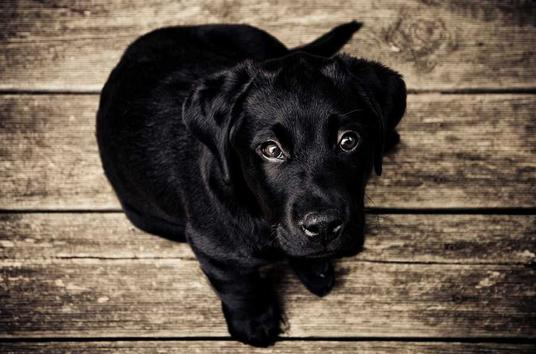

Best match: a photo of a dog (prob=1.00)


In [4]:
from io import BytesIO
import requests
from transformers import (
    CLIPProcessor, CLIPModel,
)

# CLIP: text↔image matching
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Example image and texts
url = 'https://fastly.picsum.photos/id/237/536/354.jpg?hmac=i0yVXW1ORpyCZpQ-CknuyV-jbtU7_x9EBQVhvT5aRr0'
image = Image.open(BytesIO(requests.get(url).content)).convert('RGB')
display(image)
texts = [
    "a photo of a cat",
    "a photo of a dog",
    "a photo of a horse"
]

inputs = clip_processor(text=texts, images=image, return_tensors="pt", padding=True).to(device)
outputs = clip_model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)
best_idx = probs.argmax().item()
print(f"Best match: {texts[best_idx]} (prob={probs[0, best_idx]:.2f})")

## 5. Example: BLIP-2 Image Captioning
Generate a caption for an input image.

In [ ]:
from transformers import (
    Blip2Processor, Blip2ForConditionalGeneration
)

# BLIP-2: image captioning
blip2_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip2_model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b").to(device)

inputs = blip2_processor(images=image, return_tensors="pt").to(device)
generated_ids = blip2_model.generate(**inputs)
caption = blip2_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Caption:", caption)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   8%|7         | 409M/5.39G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   9%|8         | 944M/10.9G [00:00<?, ?B/s]

## 6. Example: DINOv2 Embeddings + FAISS Similarity Search
Compute image embeddings and perform similarity search using FAISS.

In [ ]:
import faiss
import numpy as np

# DINOv2: image embeddings
dino_vit = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14").to(device).eval()
dino_dim = 768  # embedding size for ViT-B/14
faiss_index = faiss.IndexFlatL2(dino_dim)

# Preprocess function for DINOv2
dino_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_dino_embedding(img):
    img_t = dino_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = dino_vit(img_t).cpu().numpy().squeeze()
    return emb

# Example: add images to FAISS index
url = 'https://images.unsplash.com/photo-1518717758536-85ae29035b6d'
image = Image.open(BytesIO(requests.get(url).content)).convert('RGB')
url2 = 'https://images.unsplash.com/photo-1506748686214-e9df14d4d9d0'
image2 = Image.open(BytesIO(requests.get(url2).content)).convert('RGB')

images = [image, image2]  # Replace with your images
embeddings = [get_dino_embedding(img) for img in images]
faiss_index.add(np.stack(embeddings))

# Query with a new image
# image of a dog:
query_url = 'https://images.unsplash.com/photo-1560807707-8cc77767d783'
query_img = Image.open(BytesIO(requests.get(query_url).content)).convert('RGB')

query_emb = get_dino_embedding(query_img).reshape(1, -1)
D, I = faiss_index.search(query_emb, k=1)
print(f"Most similar image index: {I[0][0]}, distance: {D[0][0]:.2f}")

Using cache found in /Users/aguschin/.cache/torch/hub/facebookresearch_dinov2_main


: 